#Exploratory Data Analysis (EDA)

**Goal:** Deeply analyze the UFC dataset through visualizations to understand patterns, relationships, and insights that will inform our modeling approach.

**Date:** 1/2/2026

**Key Questions:**
1. What features have the strongest relationship with winning?
2. How do winners differ from losers?
3. Are there patterns by weight class or over time?
4. How accurate are betting odds as predictors?

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style and display options
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Load the cleaned dataset from Step 1
df = pd.read_csv('../data/raw/ufc-master.csv')  

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Basic info
print(f"Dataset loaded: {df.shape[0]:,} fights, {df.shape[1]} features")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

Dataset loaded: 6,528 fights, 118 features
Date range: 2010-03-21 to 2024-12-07


---
## 1. Numeric Feature Distributions

**Goal:** 
Understand the shape, spread, and outliers of numeric features.

**We'll analyze:**
- Fighter physical attributes (height, reach, weight, age)
- Fighter experience (wins, losses, rounds fought)
- In-fight statistics (strikes, takedowns, etc.)

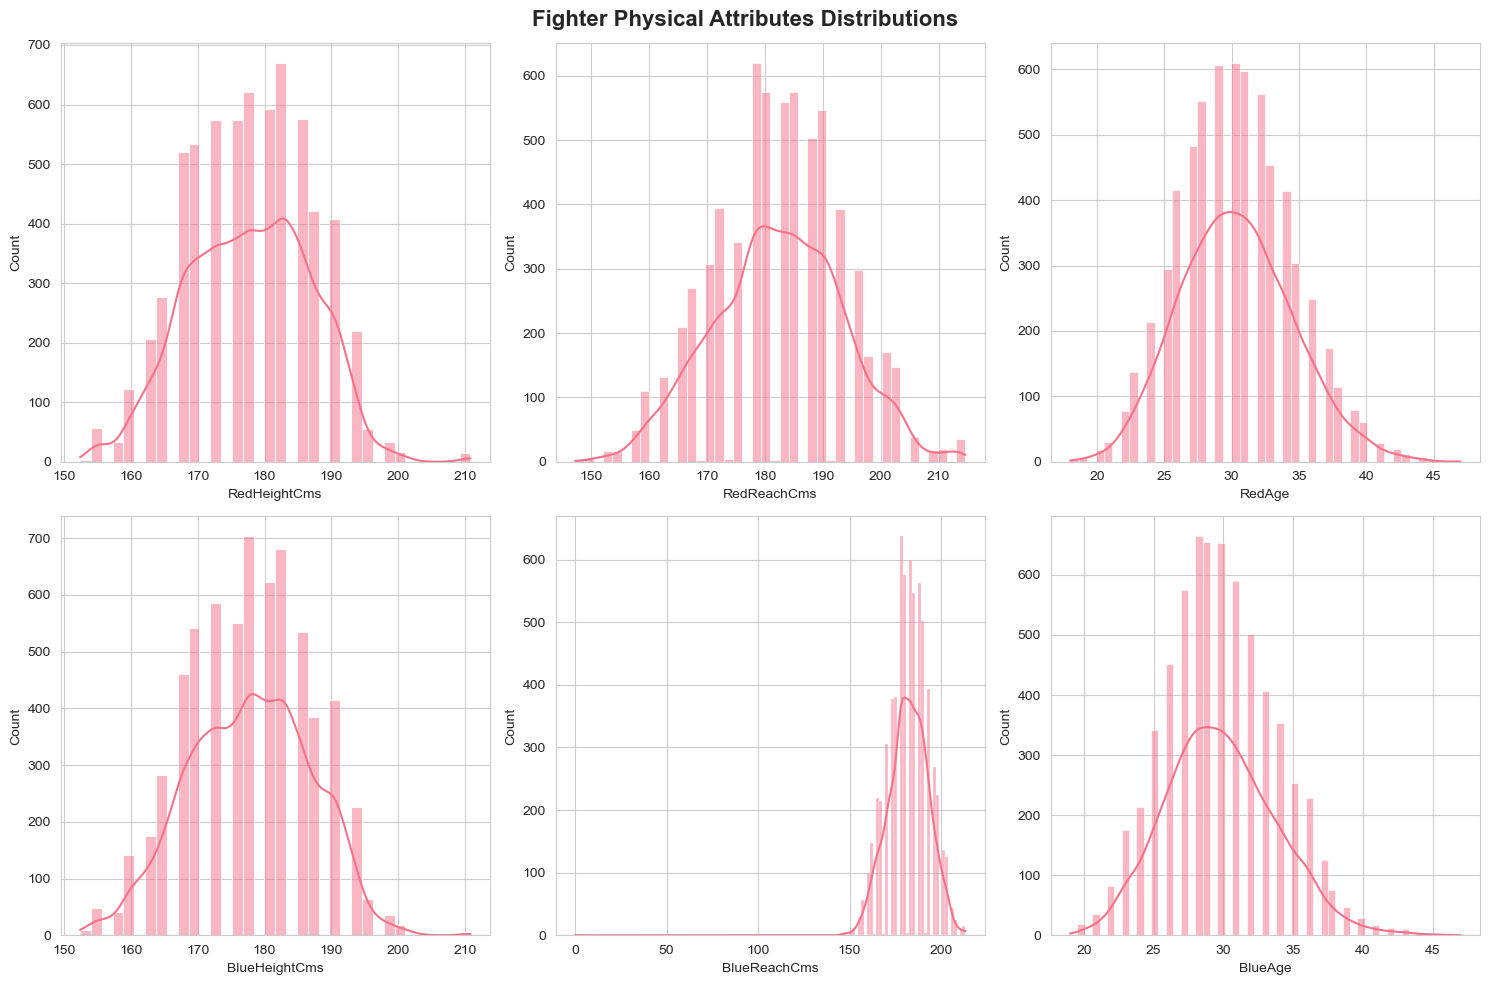

count    6528.000000
mean       29.805607
std         3.959623
min        19.000000
25%        27.000000
50%        30.000000
75%        32.000000
max        47.000000
Name: BlueAge, dtype: float64

In [ ]:
# Create distribution plots for physical attributes
# Features to analyze: RedHeightCms, RedReachCms, RedAge, BlueHeightCms, BlueReachCms, BlueAge

# Create subplots for Red fighter physical stats
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Fighter Physical Attributes Distributions', fontsize=16, fontweight='bold')

# TODO: Create histplot for RedHeightCms in axes[0, 0]
sns.histplot(data=df, x = 'RedHeightCms',kde = True, ax = axes[0,0])
# TODO: Create histplot for RedReachCms in axes[0, 1]
sns.histplot(data= df, x = 'RedReachCms',kde = True, ax = axes[0,1])
# TODO: Create histplot for RedAge in axes[0, 2]
sns.histplot(data= df, x = 'RedAge',kde = True, ax = axes[0,2])
# TODO: Create histplot for BlueHeightCms in axes[1, 0]
sns.histplot(data= df, x = 'BlueHeightCms',kde = True, ax = axes[1,0])
# TODO: Create histplot for BlueReachCms in axes[1, 1]
sns.histplot(data= df, x = 'BlueReachCms',kde = True, ax = axes[1,1])
# TODO: Create histplot for BlueAge in axes[1, 2]
sns.histplot(data= df, x = 'BlueAge',kde = True, ax = axes[1,2])


plt.tight_layout()
plt.show()

# TODO: Print summary statistics for these features
df['RedHeightCms'].describe()
df['RedReachCms'].describe()
df['RedAge'].describe()
df['BlueHeightCms'].describe()
df['BlueReachCms'].describe()
df['BlueAge'].describe()

---
## 2. Correlation Analysis

**Goal:** Identify which features correlate with each other and with winning.

**Key Questions:**
- Which features are highly correlated (redundant)?
- Which features correlate with winning?
- Are there unexpected relationships?

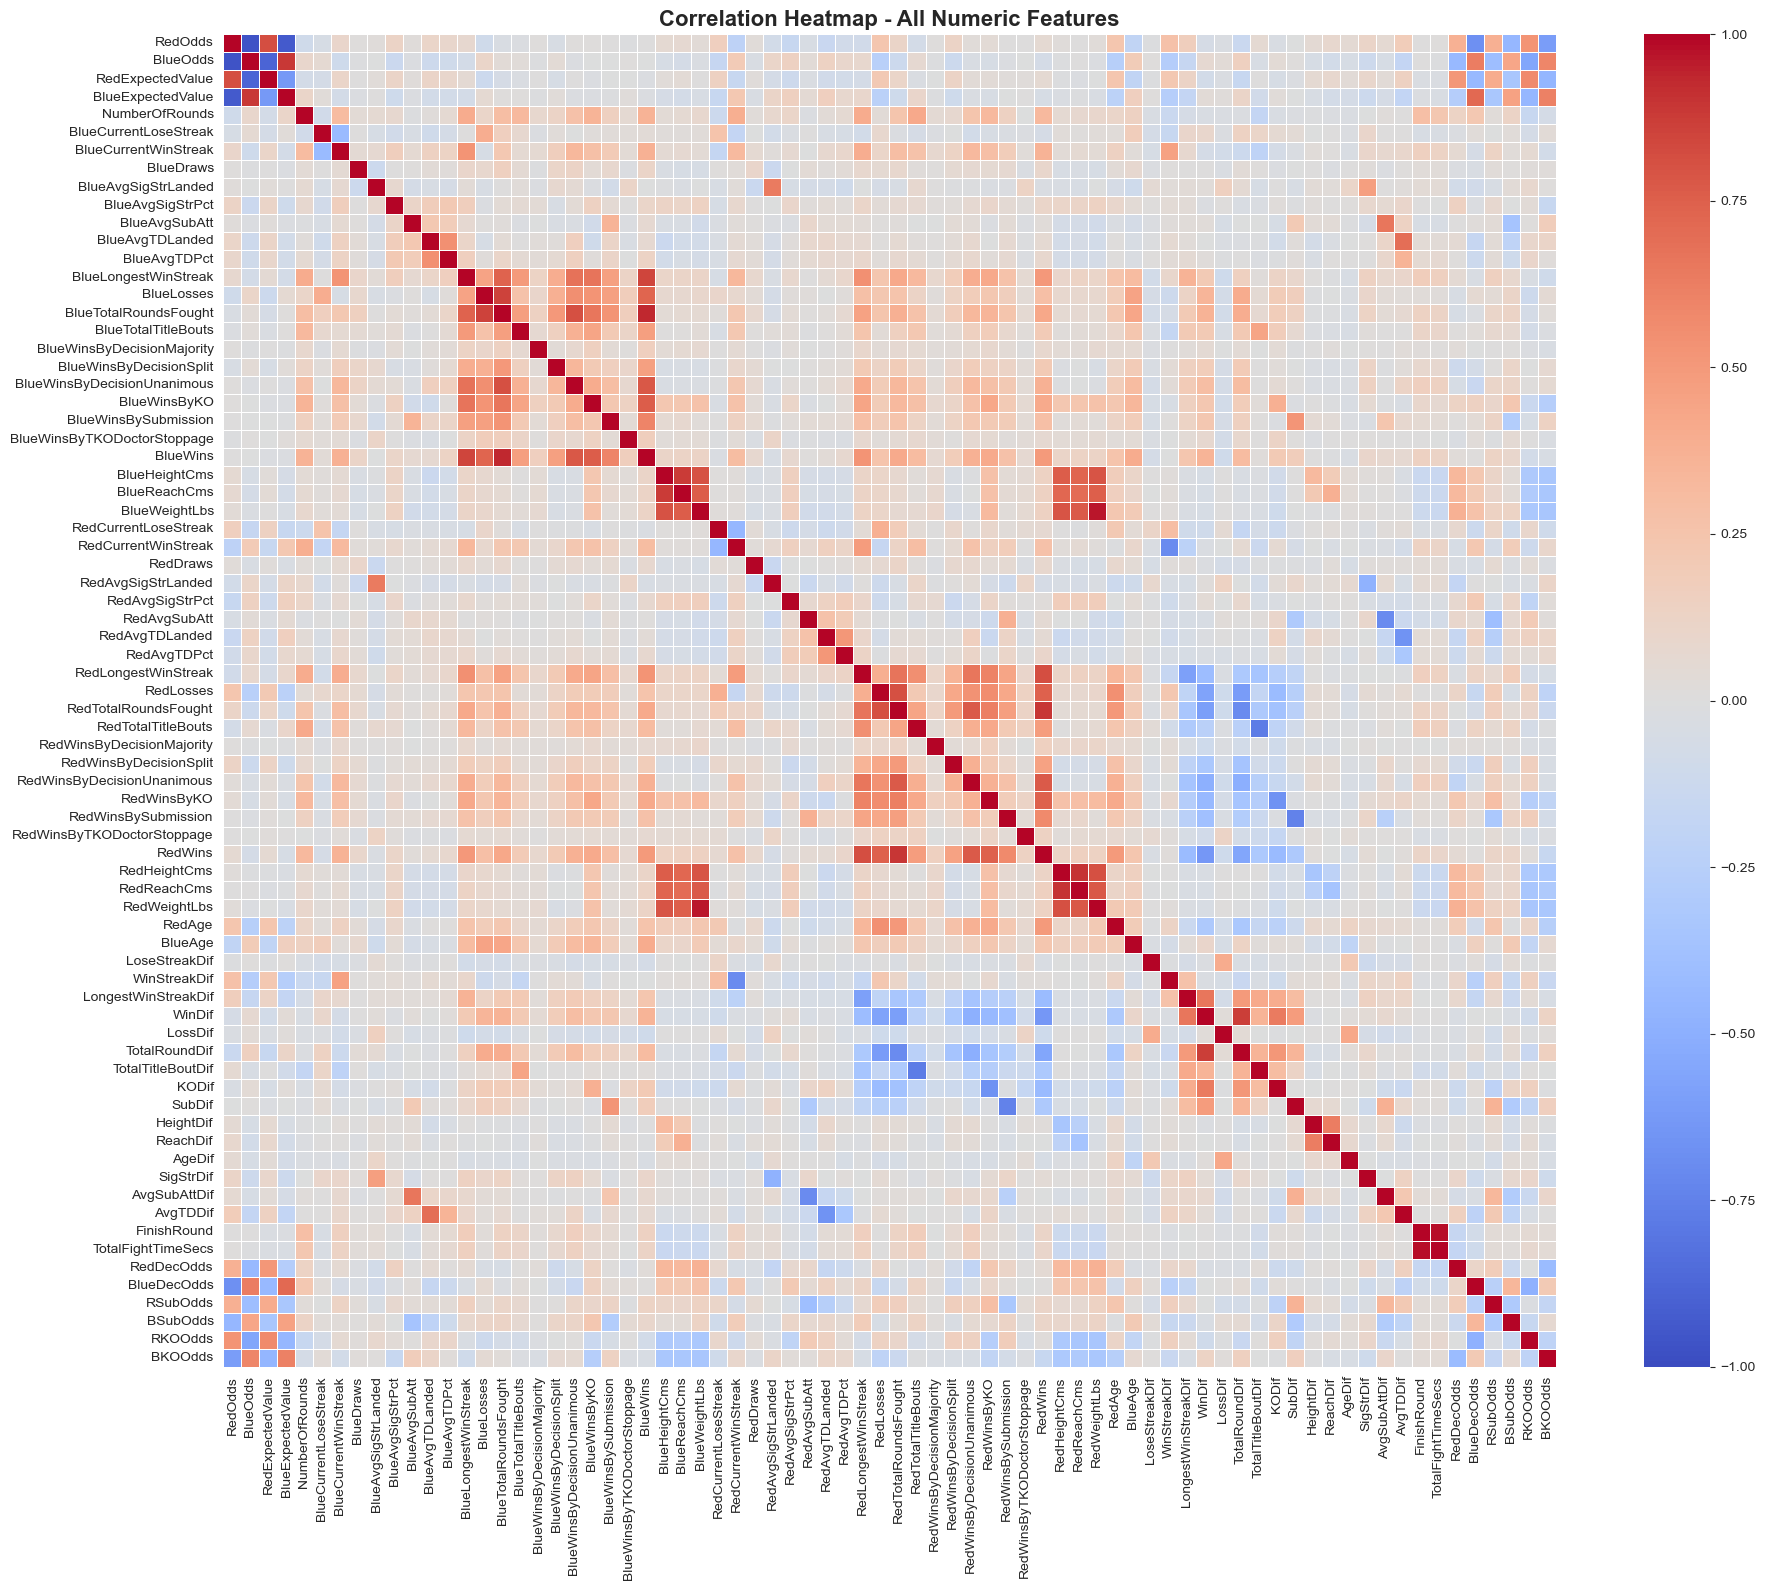


=== Highly Correlated Feature Pairs (|r| > 0.8) ===
FinishRound                    <-> TotalFightTimeSecs            : r = +0.978
BlueWeightLbs                  <-> RedWeightLbs                  : r = +0.965
RedOdds                        <-> BlueOdds                      : r = -0.964
BlueTotalRoundsFought          <-> BlueWins                      : r = +0.934
RedOdds                        <-> BlueExpectedValue             : r = -0.933
RedHeightCms                   <-> RedReachCms                   : r = +0.901
RedTotalRoundsFought           <-> RedWins                       : r = +0.893
BlueOdds                       <-> BlueExpectedValue             : r = +0.886
BlueOdds                       <-> RedExpectedValue              : r = -0.885
BlueHeightCms                  <-> BlueReachCms                  : r = +0.881
WinDif                         <-> TotalRoundDif                 : r = +0.874
BlueLosses                     <-> BlueTotalRoundsFought         : r = +0.853
BlueLongest

In [ ]:
# Create correlation heatmap for numeric features

# Select only numeric columns (exclude categorical)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove ranking columns (95%+ missing) and some redundant columns
cols_to_exclude = [col for col in numeric_cols if 'Rank' in col]
cols_to_exclude += ['EmptyArena']  # COVID feature, not predictive

# Keep only relevant columns
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, 
            annot=False,  # Don't show numbers (too cluttered)
            cmap='coolwarm',  # Red = positive, Blue = negative
            center=0,  # White = zero correlation
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5)

plt.title('Correlation Heatmap - All Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (|r| > 0.8)
print("\n=== Highly Correlated Feature Pairs (|r| > 0.8) ===")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

# Sort by correlation strength
high_corr = sorted(high_corr, key=lambda x: abs(x['Correlation']), reverse=True)

for pair in high_corr[:15]:  # Show top 15
    print(f"{pair['Feature 1']:30s} <-> {pair['Feature 2']:30s}: r = {pair['Correlation']:+.3f}")

---
## 3. Correlation with Target Variable (Winning)

**Goal:** Identify which features most strongly predict fight outcomes.


=== Top 20 STRONGEST Correlations with Red Winning ===

 1. BlueOdds                      : r = +0.350  (Red advantage)
 2. RedOdds                       : r = -0.342  (Blue advantage)
 3. RedExpectedValue              : r = -0.323  (Blue advantage)
 4. BlueExpectedValue             : r = +0.318  (Red advantage)
 5. BWFlyweightRank               : r = -0.255  (Blue advantage)
 6. BlueDecOdds                   : r = +0.233  (Red advantage)
 7. BKOOdds                       : r = +0.208  (Red advantage)
 8. RKOOdds                       : r = -0.197  (Blue advantage)
 9. RWFlyweightRank               : r = -0.192  (Blue advantage)
10. BWelterweightRank             : r = -0.189  (Blue advantage)
11. BSubOdds                      : r = +0.179  (Red advantage)
12. RedDecOdds                    : r = -0.171  (Blue advantage)
13. BWStrawweightRank             : r = -0.166  (Blue advantage)
14. RSubOdds                      : r = -0.157  (Blue advantage)
15. RHeavyweightRank              : r 

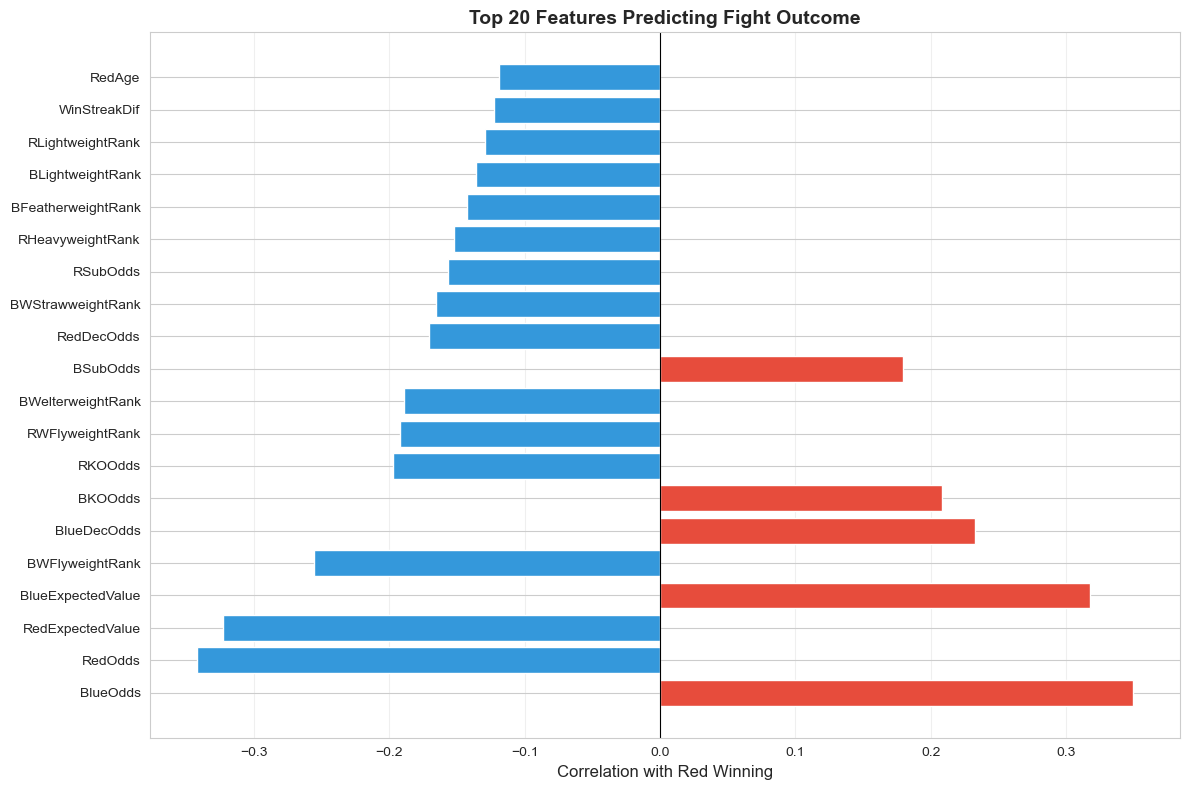

In [ ]:
# Find and print top 20 features correlated with winning

# Remove RedWon from the results (correlation with itself = 1.0)
redwon_corr = redwon_corr.drop('RedWon')

# Sort by ABSOLUTE value to find strongest correlations
redwon_abs = redwon_corr.abs().sort_values(ascending=False)

# Get top 20 strongest correlations
top_20_features = redwon_abs.head(20).index

# Print with ACTUAL values (including sign)
print("\n=== Top 20 STRONGEST Correlations with Red Winning ===\n")
for i, feature in enumerate(top_20_features, 1):
    actual_corr = redwon_corr[feature]  # Get the real value with sign
    direction = "Red advantage" if actual_corr > 0 else "Blue advantage"
    print(f"{i:2d}. {feature:30s}: r = {actual_corr:+.3f}  ({direction})")

# Visualize with horizontal bar chart
plt.figure(figsize=(12, 8))
top_20_values = [redwon_corr[feat] for feat in top_20_features]
colors = ['#e74c3c' if v > 0 else '#3498db' for v in top_20_values]

plt.barh(range(20), top_20_values, color=colors)
plt.yticks(range(20), top_20_features)
plt.xlabel('Correlation with Red Winning', fontsize=12)
plt.title('Top 20 Features Predicting Fight Outcome', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. Winners vs Losers Comparison

**Goal:** Visualize how winners differ from losers across key attributes.

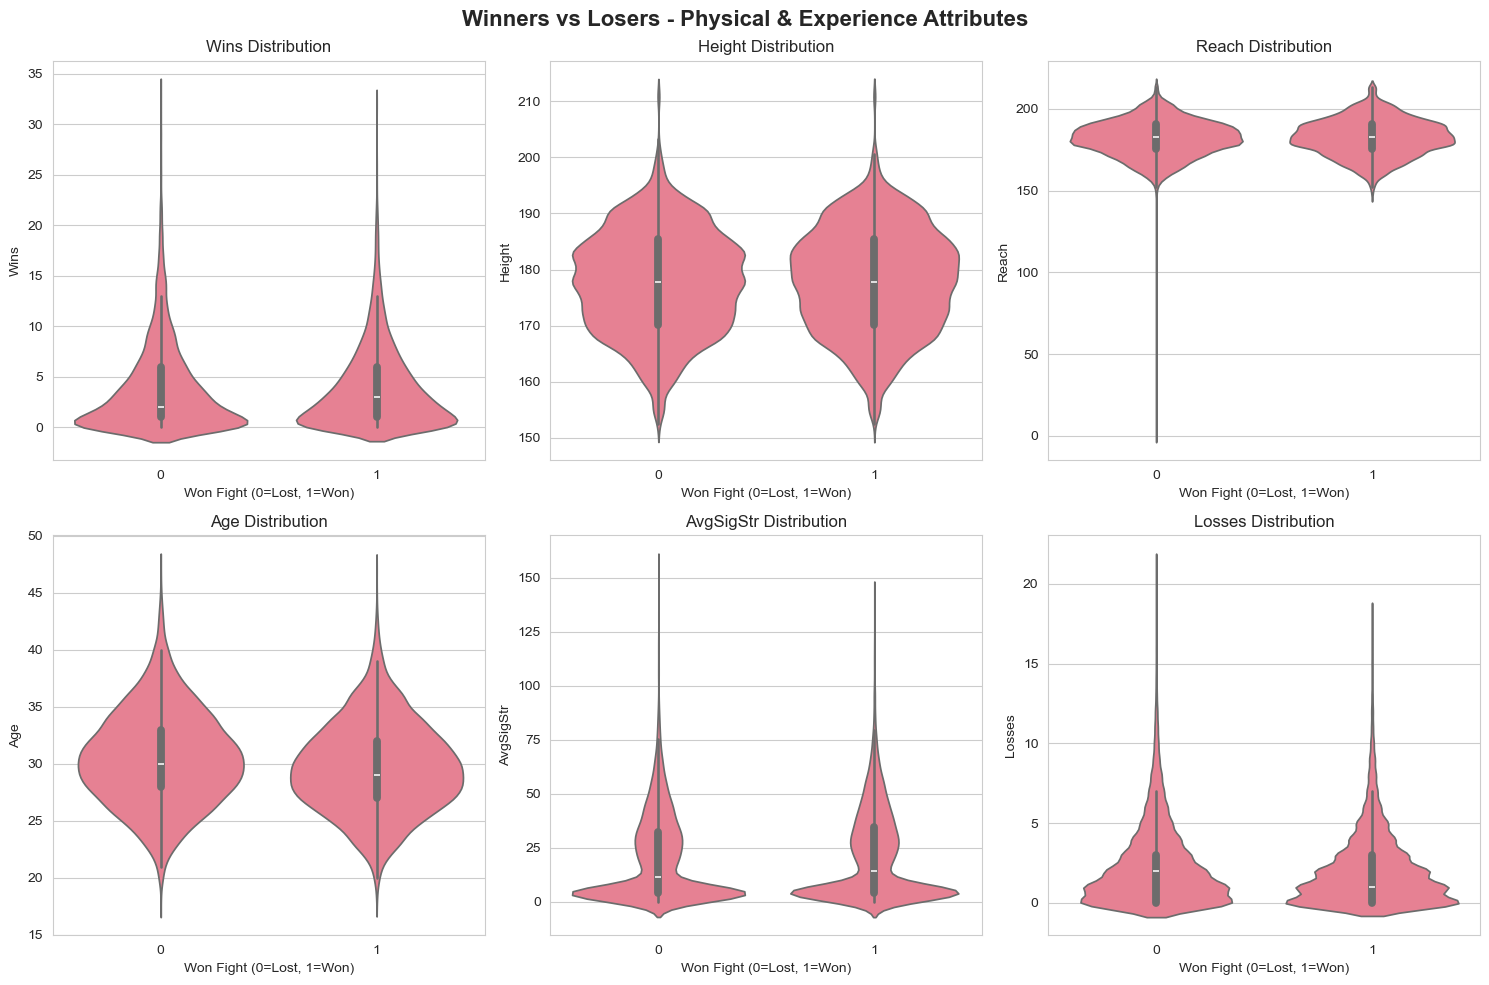


=== Mean Values: Winners vs Losers ===

         Wins      Height       Reach        Age  AvgSigStr    Losses
Won                                                                  
0    3.856005  177.694121  182.020643  30.491115  19.890681  2.340227
1    3.917739  177.930346  182.552466  29.674020  21.146810  2.090227


In [ ]:
# Create winner/loser comparison for key features

# First, create a dataset with winner's stats
# We need to "normalize" the data so Red and Blue are treated equally

# Create two dataframes: one for Red fighters, one for Blue fighters
# Then mark who won

# For Red fighters
red_fighters = df[['RedWins', 'RedLosses', 'RedHeightCms', 'RedReachCms', 
                   'RedAge', 'RedAvgSigStrLanded', 'RedOdds']].copy()
red_fighters.columns = ['Wins', 'Losses', 'Height', 'Reach', 'Age', 'AvgSigStr', 'Odds']
red_fighters['Won'] = (df['Winner'] == 'Red').astype(int)

# For Blue fighters
blue_fighters = df[['BlueWins', 'BlueLosses', 'BlueHeightCms', 'BlueReachCms',
                    'BlueAge', 'BlueAvgSigStrLanded', 'BlueOdds']].copy()
blue_fighters.columns = ['Wins', 'Losses', 'Height', 'Reach', 'Age', 'AvgSigStr', 'Odds']
blue_fighters['Won'] = (df['Winner'] == 'Blue').astype(int)

# Combine them
all_fighters = pd.concat([red_fighters, blue_fighters], ignore_index=True)

# Create violin plots comparing winners vs losers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Winners vs Losers - Physical & Experience Attributes', fontsize=16, fontweight='bold')

features_to_plot = ['Wins', 'Height', 'Reach', 'Age', 'AvgSigStr', 'Losses']

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    
    # Create violin plot
    sns.violinplot(data = all_fighters,x = 'Won', y=feature, ax= axes[row,col])
    axes[row,col].set_xlabel('Won Fight (0=Lost, 1=Won)')
    axes[row,col].set_title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

# Print statistical comparison
print("\n=== Mean Values: Winners vs Losers ===\n")
print(all_fighters.groupby('Won')[features_to_plot].mean())